# Coding your own RNN

Using this pre-filled notebook, we will code our own RNN for sentence classification. For now, we'll keep using IMDB, as the goal of this part is to understand how an RNN works.

Unlike our previous lab, we will also learn the embedding layer. Which means we need to deal with vocabulary by ourselves.

In [2]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

## Dataset
We load the dataset and split the training set in a stratified train/validation set.

In [3]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/Users/rb2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /Users/rb2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /Users/rb2/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

## Vocabulary (1 point)

**\[1 point\]** Build your own vocabulary. The [example provided in torchtext documentation](https://pytorch.org/text/stable/vocab.html#id1) might be of help.
* Don't forge to setup the `min_freq` parameter to not include unfrequent noise.
* You will need a tokenizer. Reuse the `basic_english` one from the our previous lab.
* For an RNN we need two special tokens: `<unk>`, for unknown words, and `<pad>` for padding.

In [4]:
from collections import Counter

tokenizer = get_tokenizer("basic_english")
def build_vocabulary(dataset: np.ndarray, tokenizer: Callable) -> Vocab:
    tokens = tokenizer(" ".join(dataset["text"]))
    counter = Counter(tokens)
    return vocab(counter, min_freq=10, specials=["<unk>", "<pad>"])

vocabulary = build_vocabulary(train_df, tokenizer)

# set index for unknown and padding tokens
vocabulary.set_default_index(vocabulary["<unk>"])


## Vectorize and batch the input (3 points)

As seen in class, our model should take one-hot encoded vectors corresponding to the each token vocabulary id. However, computing a vector x matrix multiplication for every input is unnecessarily costly. Multiplying a one-hot vector with a matrix is the equivalent of taking one row of the matrix. In pyTorch, we provide ids for each token which will be used as input to an `nn.Embedding` layer. The id is simply the row in the embedding matrix.

**\[1 point\]** Fill the `vectorize_text` function returning a 1D torch tensor of `torch.long` for each input text.

In [5]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    return torch.tensor(
        [vocabulary[token] for token in tokenizer(text)], dtype=torch.long
    )


In [6]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

Check the function is working correctly, especially it should return the right special id for unknown words.

In [7]:
text_pipeline("Some text I am thinking about... ragafqfa")

tensor([  39, 4850,   11,  265,  646,    8,   27,   27,   27,    0])

In [8]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

To speed up the training process, we turn the inputs into batches, as we did last time. For batches to work, every line must have the same lengths. Last time, it was implicit as only a vector (the average of all embeddings) was provided. This time, every line has the length of a different review.

To go around this problem, we use padding. So every line within a batch is padded to the length of its longest element.

* **\[1 point\]** Fill the data generator function.
* **\[1 point\]** On which side should you pad and why?

In [39]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X), batch_size):
        X_batch = nn.utils.rnn.pad_sequence(
            X[i : i + batch_size], padding_value=pad_id, batch_first=True
        )
        y_batch = torch.tensor(y[i : i + batch_size], dtype=torch.long)
        yield X_batch, y_batch

In [40]:
pad_token = "<pad>"
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

In [41]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Classifier (3 points)

**\[3 points\]** Code your own RNN. Fill the `RNN` class correctly. Remember an RNN has 3 matrices and an embedding layer (see course slide 61).
* The embedding layer turns a one-hot vectors into dense vectors.
* The first matrix (W) connects the embedding to the hidden layer.
  * `embedding_size -> hidden_size`
* The second matrix (U) connect the previous hidden layer to the current one.
  * `hidden_size -> hidden_size`
* These to vectors are added and go through an activation function (e.g. $h_t = tanh(Wx_i+Uh_{t-1})$).
* The last matrix (V) connects the hidden layer to the hidden layer to the output.
  * `hidden_size -> 1`
* Donc forget to add an `init_hidden` function which initialize the first hidden layer to 0.

In [45]:
# code our own RNN without pytorch

# The RNN has 3 matrices and an embedding layer.
# The embedding layer turns one-hot encoded vectors into dense vectors.
# The first matrix (W) is the input matrix,  which connects the embedding layer to the hidden layer.
# embedding_size -> hidden_size
# The second matrix (U) is the hidden matrix, which connects the previous hidden layer to the current hidden layer.
# hidden_size -> hidden_size
# These vectors are added and go through a non-linear activation function (tanh).
# The last matrix (V) is the output matrix, which connects the hidden layer to the output layer.
# hidden_size -> 1
# Don't forget to add an init_hidden function which initializes the first hidden layer to 0.

class RNN(nn.Module):
    def __init__(self, vocabulary_size: int, embedding_size: int, hidden_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.W = nn.Linear(embedding_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)
        self.tanh = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        h = torch.zeros(x.shape[0], self.U.in_features).to(device)
        for i in range(x.shape[1]):
            h = self.tanh(self.W(x[:, i, :]) + self.U(h))
        return self.V(h)

    def init_hidden(self, batch_size: int) -> torch.Tensor:
        return torch.zeros(batch_size, self.U.in_features).to(device)

## Training (2 points)

Training is a bit different than usual. We will need to sequentially (but in "batch parallel") go through an input, keeping track of the hidden layer, and use the last output as prediction.

**\[2 point\]** Code the training loop.
* Note that for each batch, you need to loop through the whole input and use the output of the last token as input to your criterion.
* Keep the best model evaluated on the validation set.
* Plot the training and validation losses.
* Training will take some time (~30 min on a T4 GPU). Make sure your results appear in the notebook.

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Early stopping after 4 epochs.


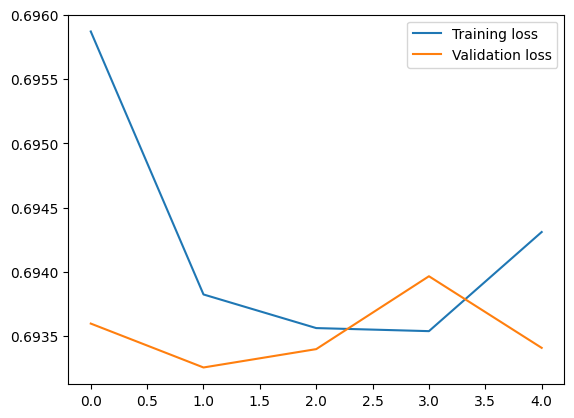

In [50]:
n_embedding = 32
n_hidden = 64
model = RNN(len(vocabulary.get_itos()), n_embedding, n_hidden).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# For the training, we need to sequentially (but in "batch parallel") go through an input
# keeping track of the hidden layer, and use the last output as prediction.
# For each batch, we need to loop through the whole input and use the output of the last token as input for our criterion.
# Keep the best model evaluated on the validation set

# use tqdm to display a progress bar
# use train_gen and valid_gen to get batches

def train(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_gen: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    valid_gen: Generator[Tuple[torch.Tensor, torch.Tensor], None, None],
    n_epochs: int,
    patience: int = 3,
) -> Tuple[nn.Module, List[float], List[float]]:
    """
    Train a model using the given criterion, optimizer and data generators.
    Args:
        model: a PyTorch module.
        criterion: a PyTorch module (the loss).
        optimizer: a PyTorch optimizer.
        train_gen: a generator returning training batches.
        valid_gen: a generator returning validation batches.
        n_epochs: the number of epochs.
        patience: the patience for early stopping [3].
    Returns:
        The trained model, the training loss and the validation loss.
    """
    train_loss = []
    valid_loss = []
    best_loss = np.inf
    epochs_without_improvement = 0
    for epoch in range(n_epochs):
        model.train()
        batch_loss = []
        for X_batch, y_batch in tqdm(train_gen()):
            optimizer.zero_grad()
            y_pred = model(X_batch.to(device)).squeeze(1)
            loss = criterion(y_pred, y_batch.to(device).float())
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        train_loss.append(np.mean(batch_loss))
        model.eval()
        batch_loss = []
        for X_batch, y_batch in valid_gen():
            y_pred = model(X_batch.to(device)).squeeze(1)
            loss = criterion(y_pred, y_batch.to(device).float())
            batch_loss.append(loss.item())
        valid_loss.append(np.mean(batch_loss))
        if valid_loss[-1] < best_loss:
            best_loss = valid_loss[-1]
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping after {epoch} epochs.")
            break
    return model, train_loss, valid_loss

model, train_loss, valid_loss = train(
    model, criterion, optimizer, train_gen, valid_gen, n_epochs=10
)

# plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(train_loss, label="Training loss")
plt.plot(valid_loss, label="Validation loss")
plt.legend()
plt.show()

    
  

## Evaluation (1 point)

* **\[1 point\]** Compute the accuracy for all 3 splits.

In [52]:
# compute the accuracy for the 3 splits

def accuracy(
    model: nn.Module, data_gen: Generator[Tuple[torch.Tensor, torch.Tensor], None, None]
) -> float:
    """
    Compute the accuracy of the model on the given data.
    Args:
        model: a PyTorch module.
        data_gen: a generator returning batches.
    Returns:
        The accuracy of the model on the given data.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in data_gen():
            y_pred = model(X_batch.to(device)).squeeze(1)
            correct += ((y_pred > 0) == y_batch.to(device)).sum().item()
            total += len(y_batch)
    return correct / total

print(f"Train accuracy: {accuracy(model, train_gen):.3f}")
print(f"Valid accuracy: {accuracy(model, valid_gen):.3f}")
print(f"Test accuracy: {accuracy(model, test_gen):.3f}")



Train accuracy: 0.504
Valid accuracy: 0.502
Test accuracy: 0.499
